### Research on Garch

In [15]:
import pandas as pd
import random
close = pd.read_parquet("db/tw/Adj_close.parquet")
close.index = pd.to_datetime(close.index)
stock_list_total = list(close.columns)
random_num = [random.randint(0, len(stock_list_total)) for _ in range(100)]
stock_list = [stock_list_total[i] for i in random_num]
stock_list = stock_list_total[-100:]

In [22]:
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima_model import ARMA
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2019-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

pct_change = close.pct_change(fill_method=None).dropna(how='all', axis=0)

In [44]:
def check_accuracy(series, model_fit):
    if not len(series) == len(model_fit):
        return "length of two series not matched"
    df = pd.DataFrame({"series": series, "model_fit": model_fit})
    df['signal'] = ((df['series'] > 0) & (df['model_fit'] > 0)) | ((df['series'] < 0) & (df['model_fit'] < 0))
    correct = df[df['signal'] == True]
    print(len(correct)/len(df))

In [121]:
series = pct_change['2330.TW'].iloc[-150:-50]
model = sm.tsa.arima.ARIMA(series, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit1 = model.fit()
model_fit1.pvalues, model_fit1.forecast(steps=1), series.index[-1], pct_change['2330.TW'].iloc[-50:-48]

(const     1.988510e-02
 ar.L1     7.023451e-01
 ar.L2     5.977637e-01
 ar.L3     8.354028e-01
 ar.L4     2.840728e-01
 sigma2    3.310789e-25
 dtype: float64,
 100    0.002263
 dtype: float64,
 Timestamp('2024-03-26 00:00:00'),
 Date
 2024-03-27   -0.003836
 2024-03-28   -0.012837
 Name: 2330.TW, dtype: float64)

test: model_fit1.forecast(steps=1) vs. self calculate forecast1   ==  actual (pct_change['2330.TW].iloc[-50])

In [135]:
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                2330.TW   No. Observations:                  100
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 270.861
Date:                Fri, 21 Jun 2024   AIC                           -529.721
Time:                        01:54:26   BIC                           -514.090
Sample:                             0   HQIC                          -523.395
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.329      0.020       0.001       0.007
ar.L1         -0.0507      0.133     -0.382      0.702      -0.311       0.209
ar.L2         -0.0945      0.179     -0.528      0.598      -0.446       0.257
ar.L3          0.0278      0.134      0.208      0.835      -0.234       0.290
ar.L4         -0.0861      0.080     -1.071      0.284      -0.244       0.071
sigma2         0.0003    2.5e-05     10.372      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               189.19
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.71   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
pvalues = model_fit1.params
'''
檢查有沒有
'''
a = series[-4:].values
b = pvalues[1:-1][::-1].values
c = pvalues[0] + pvalues[-1]
sums = 0
for i in range(len(a)):
    sums += a[i] * b[i]
    sums += c
sums 


0.014245772070116437

0.58


(-779.4048590165696, -761.3410472519921)

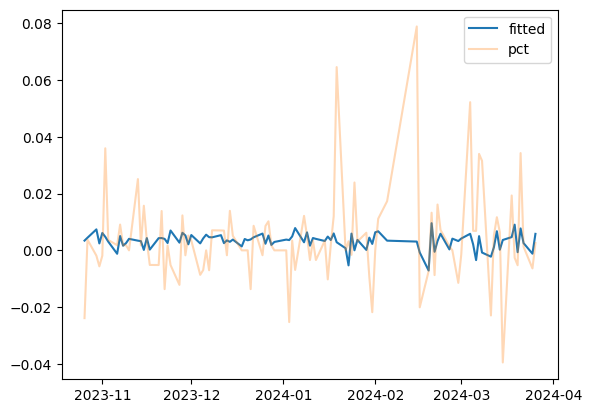

In [52]:
series = pct_change['2330.TW'].iloc[-150:-50]
model = sm.tsa.arima.ARIMA(series, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit1 = model.fit()
model_fit1.summary()
plt.plot(model_fit1.fittedvalues[:-50], alpha=1, label='fitted')
plt.plot(series[:-50], alpha=0.3, label='pct')
check_accuracy(series[:-50], model_fit1.fittedvalues[:-50])
plt.legend()
model_fit1.aic, model_fit1.bic

0.57


(-529.7213556695767, -514.0903345536482)

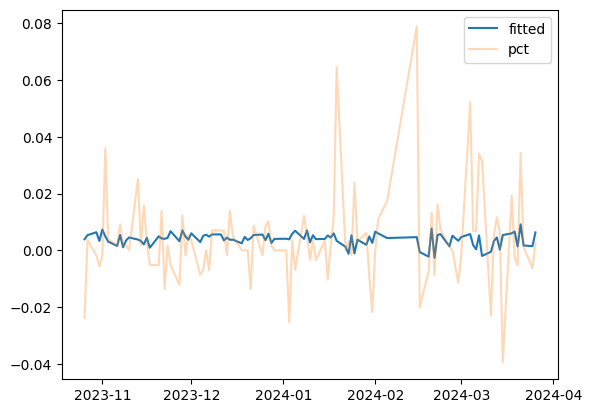

In [59]:
series = pct_change['2330.TW'].iloc[-150:-50]
model = sm.tsa.arima.ARIMA(series, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit = model.fit()
model_fit.summary()
plt.plot(model_fit.fittedvalues, alpha=1, label='fitted')
plt.plot(series, alpha=0.3, label='pct')
plt.legend()
check_accuracy(model_fit.fittedvalues, series)
model_fit.aic, model_fit.bic

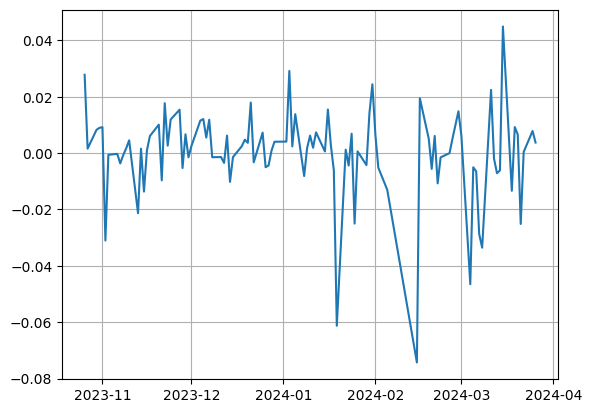

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 272.365
Date:                Thu, 20 Jun 2024   AIC                           -530.729
Time:                        22:23:22   BIC                           -512.493
Sample:                             0   HQIC                          -523.349
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.219e-05      0.002     -0.013      0.990      -0.003       0.003
ar.L1         -0.0148      0.122     -0.120      0.904      -0.255       0.225
ar.L2          0.0065      0.182      0.036      0.971      -0.350       0.363
ar.L3         -0.0148      0.133     -0.111      0.912      -0.276       0.246
ar.L4         -0.0041      0.079     -0.052      0.958      -0.159       0.151
ar.L5         -0.1729      0.100     -1.729      0.084      -0.369       0.023
sigma2         0.0003   2.92e-05      8.627      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               164.81
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.73   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
fit = model_fit.fittedvalues
residual = fit - series
plt.plot(residual)
plt.grid()
plt.show()
adfuller(residual)

model_residual = sm.tsa.arima.ARIMA(residual, order=(5, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_residual_fit = model_residual.fit()
model_residual_fit.summary()

In [72]:
fitted_residual = model_residual_fit.fittedvalues
check_accuracy(fitted_residual, residual)

0.57


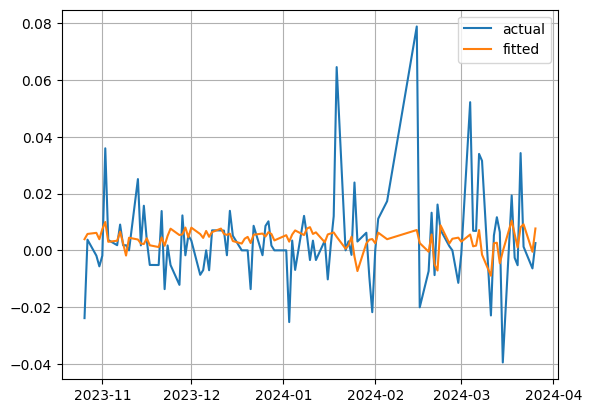

In [87]:
arima_garch_concept_fittedvalues = model_fit.fittedvalues - fitted_residual
plt.plot(series, label='actual')
plt.plot(arima_garch_concept_fittedvalues, label="fitted")
plt.legend()
plt.grid()
plt.show()

In [88]:
check_accuracy(arima_garch_concept_fittedvalues, series)

0.55


(-10.130263627603323,
 8.956534199926078e-18,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -463.84773944009476)

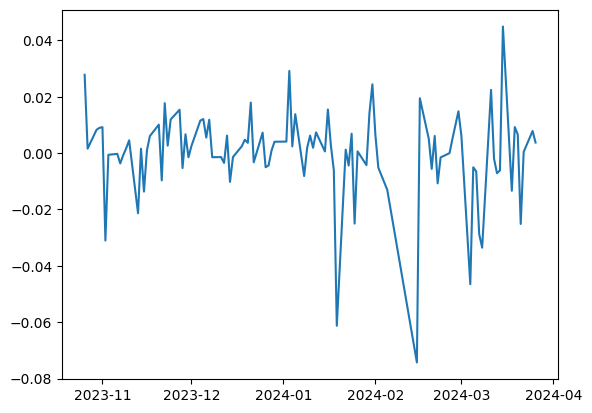

In [8]:
from statsmodels.tsa.stattools import adfuller

garch_data = model_fit.fittedvalues-series
plt.plot(garch_data)
adfuller(garch_data.dropna())

garch: predict next actual_value - prediction

and for ar model we get predicted value, 

+/- garch prediction of actual - prediction, we get actual prediction.

### Comparison: arima vs. arima garch

In [9]:
# loop through ar_t from 1 to 5
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

pct_change = close.pct_change(fill_method=None).dropna(how='all', axis=0)
pct_change.index = pd.to_datetime(pct_change.index)
'''
ar_t = 2
from ${from_t - backtest_interval} days before, 
with backtesting for ${backtest_interval} days each,
looping for ${iter} days as sample data to check accuracy
'''
ar_t = 2
from_t = 150
backtest_interval = 100
iter = from_t - backtest_interval
test = pct_change[['2330.TW']].iloc[-iter:]
for ar_t in range(1, 6):
    predictions = [0.0] * iter 
    for i in range(iter):
        train = pct_change['2330.TW'].iloc[-from_t+i:-from_t+backtest_interval+i]
        model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)
        predictions[i] = prediction.iloc[0]

    test[f'pred_{ar_t}'] = predictions
    
    # calc
    test['pos same'] = (test['2330.TW'] > 0) & (test[f'pred_{ar_t}'] > 0)
    test['neg same'] = (test['2330.TW'] < 0) & (test[f'pred_{ar_t}'] < 0)
    test['same dir'] = test['pos same'] | test['neg same']
    print(f"accuracy before garch for ar_t={ar_t}:", len(test[test['same dir'] == True])/len(test))

'''
# worse, accuracy around 0.3 from 2023-06 to 2023-12
# the pvalues have to be worse at that time interval, so the model could work
# for the stocks with no significant pvalues, set factor value to -1 or sth
'''
print("")

accuracy before garch for ar_t=1: 0.52
accuracy before garch for ar_t=2: 0.5
accuracy before garch for ar_t=3: 0.5
accuracy before garch for ar_t=4: 0.56
accuracy before garch for ar_t=5: 0.58



In [10]:
# test for best lags, maybe exclude other lags
t = 149
for i in range(5):
    train = pct_change['2330.TW'].iloc[-t+i:-t+100+i]
    model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
    model_fit = model.fit()
    prediction = model_fit.forecast(steps=1)
    print("===========")
    print(model_fit.pvalues.iloc[1:6])

ar.L1    0.601109
ar.L2    0.584096
ar.L3    0.968904
ar.L4    0.151602
ar.L5    0.266640
dtype: float64
ar.L1    0.618993
ar.L2    0.599465
ar.L3    0.936515
ar.L4    0.152526
ar.L5    0.201659
dtype: float64
ar.L1    0.606233
ar.L2    0.591512
ar.L3    0.907020
ar.L4    0.146995
ar.L5    0.199925
dtype: float64
ar.L1    0.611463
ar.L2    0.665042
ar.L3    0.882106
ar.L4    0.161712
ar.L5    0.221155
dtype: float64
ar.L1    0.561523
ar.L2    0.670858
ar.L3    0.934330
ar.L4    0.146044
ar.L5    0.221185
dtype: float64


In [11]:
# params for model_fit(summary)
summary = model_fit.summary()
coefficients = model_fit.params
standard_errors = model_fit.bse
p_values = model_fit.pvalues
aic = model_fit.aic
bic = model_fit.bic
p_values

const     6.985348e-03
ar.L1     5.615231e-01
ar.L2     6.708576e-01
ar.L3     9.343299e-01
ar.L4     1.460442e-01
ar.L5     2.211851e-01
sigma2    7.512556e-18
dtype: float64

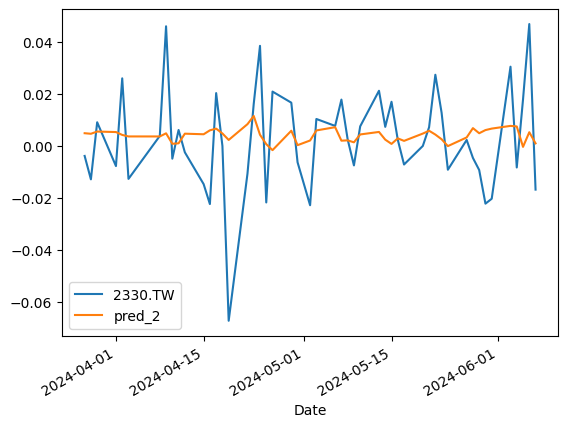

accuracy before garch: 0.5


In [12]:
# single plot actual - predict = residual, used for garch model
test['neg same'] = (test['2330.TW'] < 0) & (test['pred_2'] < 0)
test['pos same'] = (test['2330.TW'] > 0) & (test['pred_2'] > 0)
test['same dir'] = test['pos same'] | test['neg same']
test['2330.TW'].plot()
test['pred_2'].plot()
plt.legend()
plt.show()
print("accuracy before garch:", len(test[test['same dir'] == True])/len(test))